In [1]:
# import libraries
import math

import numpy
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch
import random
import time

# import Koopman Libraries
from core.koopman_core_linear import KoopDNN_linear, KoopmanNet_linear, KoopmanNetCtrl_linear
# from core.koopman_linear_time_delay import KoopDNN, KoopmanNet, KoopmanNetCtrl
from sklearn import preprocessing
from core.util import fit_standardizer
from models.koop_model import model_matricies,lift

# Import Adaptive Koopman
from core.adapt_net_linear import AdaptNet_linear
import scipy.io


from dynamics.sync_pendulum import sync_pendulum_data_gen_multi, FK_solver

## System Generation

In [2]:
"""Choose the type of Koopman representation"""
linear = True

## Data Generation

In [3]:
# define system pars
sys_pars = {}
N = 5
num_states = 2*N
num_inputs = 1
dt = 0.01
sys_pars['num_states'] = num_states
sys_pars['num_inputs'] = num_inputs

sys_pars['N'] = N  #number of pendulums
sys_pars['f_origin'] = 0
sys_pars['m'] = 0.017
sys_pars['l'] = 0.1
sys_pars['gamma'] = 3.1956332e-4
sys_pars['b'] = 6.819e-4
sys_pars['k'] = 0.079
sys_pars['J'] = sys_pars['m']*sys_pars['l']**2
sys_pars['g'] = 9.81
sys_pars['dt'] = dt

adj_mat = np.diag(np.ones((N-1)), 1) + np.diag(np.ones((N-1)), -1)
L = np.diag(sum(adj_mat)) - adj_mat
sys_pars['L'] = L
sys_pars['d'] = np.hstack((np.array([1]),np.zeros((N-1)))).reshape((N,-1))
sys_pars['F_type'] = 'sinusoidal' #type of inputs used to generate data
sys_pars['F_max'] = 0.1 #maximum amplitude of torque to generate dataset

sys_pars['uncertainty'] = 'NA'
sys_pars['amp_frac'] = 0


In [4]:
# # system pars
sys_pars_new = {} #system parameters for the uncertain system
percent_change = 10 #percentage change in the parameters of the system

sys_pars_new['num_states'] = num_states
sys_pars_new['num_inputs'] = num_inputs

sys_pars_new['N'] = N
sys_pars_new['f_origin'] = sys_pars['f_origin']
sys_pars_new['m'] = sys_pars['m'] * (1 + random.choice([-1,1])*percent_change/100)
sys_pars_new['l'] = sys_pars['l'] * (1 + random.choice([-1,1])*percent_change/100)
sys_pars_new['gamma'] = sys_pars['gamma'] * (1 + random.choice([-1,1])*percent_change/100)
sys_pars_new['b'] = sys_pars['b'] * (1 + random.choice([-1,1])*percent_change/100)
sys_pars_new['k'] = sys_pars['k'] * (1 + random.choice([-1,1])*percent_change/100)
sys_pars_new['J'] = sys_pars_new['m']*sys_pars_new['l']**2
sys_pars_new['g'] = sys_pars['g']
sys_pars_new['F_max'] = sys_pars['F_max']
sys_pars_new['dt'] = dt
sys_pars_new['L'] = L
sys_pars_new['d'] = sys_pars['d']
sys_pars_new['F_type'] = sys_pars['F_type']

sys_pars_new['uncertainty'] = 'NA' #['NA','periodic','constant']
sys_pars_new['amp'] = 0.05 #amplitude of torque disturbance
sys_pars_new['freq'] = 5 #[5,10,100,500.1000] frequency of periodic disturbance

sensor_noise = False
SNR_DB = 30 #[20,25,30,35,40] #signal-to-noise ration of sensor noise

In [5]:
num_traj = 150
num_train = int(0.75*num_traj)
num_val = num_traj - num_train

num_snaps = 1000

In [6]:
X, X_changed, U = sync_pendulum_data_gen_multi(num_traj, num_snaps, sys_pars, sys_pars_new,sensor_noise, SNR_DB)

In [7]:
np.save('coupled_pendulum_state_data',X)
np.save('coupled_pendulum_input_data',U)

In [8]:
if sys_pars_new['uncertainty'] == 'constant':
    if sensor_noise:
        img_pth = 'saved_models/sync_pendulum/linear/nonparametric/constant/sensor noise/'+ str(sys_pars_new['amp'])+ '/'+ str(SNR_DB)
    else:
        img_pth = 'saved_models/sync_pendulum/linear/nonparametric/constant/no sensor noise/'+ str(sys_pars_new['amp'])
elif sys_pars_new['uncertainty'] == 'periodic':
    if sensor_noise:
        img_pth = 'saved_models/sync_pendulum/linear/nonparametric/periodic/sensor noise/'+ str(sys_pars_new['freq'])+ '/'+ str(SNR_DB)
    else:
        img_pth = 'saved_models/sync_pendulum/linear/nonparametric/periodic/no sensor noise/'+ str(sys_pars_new['freq'])
else:
    if sensor_noise:
        img_pth = 'saved_models/sync_pendulum/linear/parametric/sensor_noise/'+str(percent_change) +'/'+ str(SNR_DB)
    else:
        img_pth = 'saved_models/sync_pendulum/linear/parametric/no_sensor_noise/'+str(percent_change)

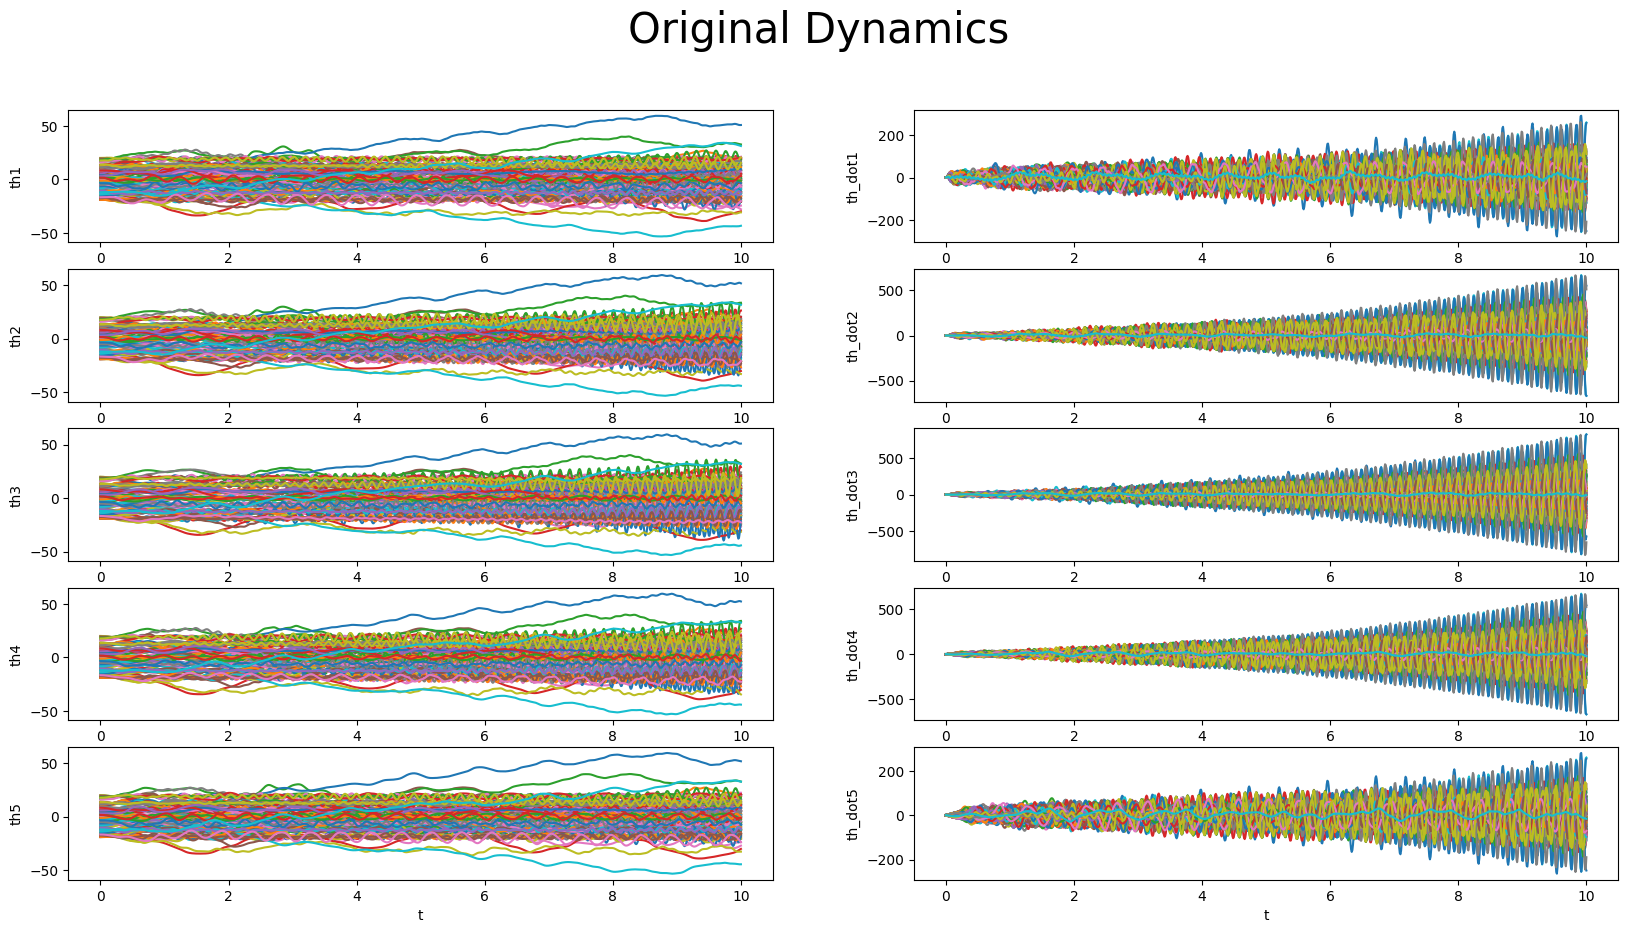

In [9]:
# Overall data
leg = ['th','th_dot']
t_train = np.linspace(0,dt*num_snaps,num_snaps)
plt.figure(figsize = (20,10))
for j in range(num_traj):
    for i in range(N):
        plt.subplot(N,2,2*i+1)
        plt.xlabel("t")
        plt.ylabel(leg[0]+str(i+1))
        plt.plot(t_train,X[j,:,2*i])

        plt.subplot(N,2,2*i+2)
        plt.xlabel("t")
        plt.ylabel(leg[1]+str(i+1))
        plt.plot(t_train,X[j,:,2*i+1])

plt.suptitle("Original Dynamics", fontsize=30)
plt.show()

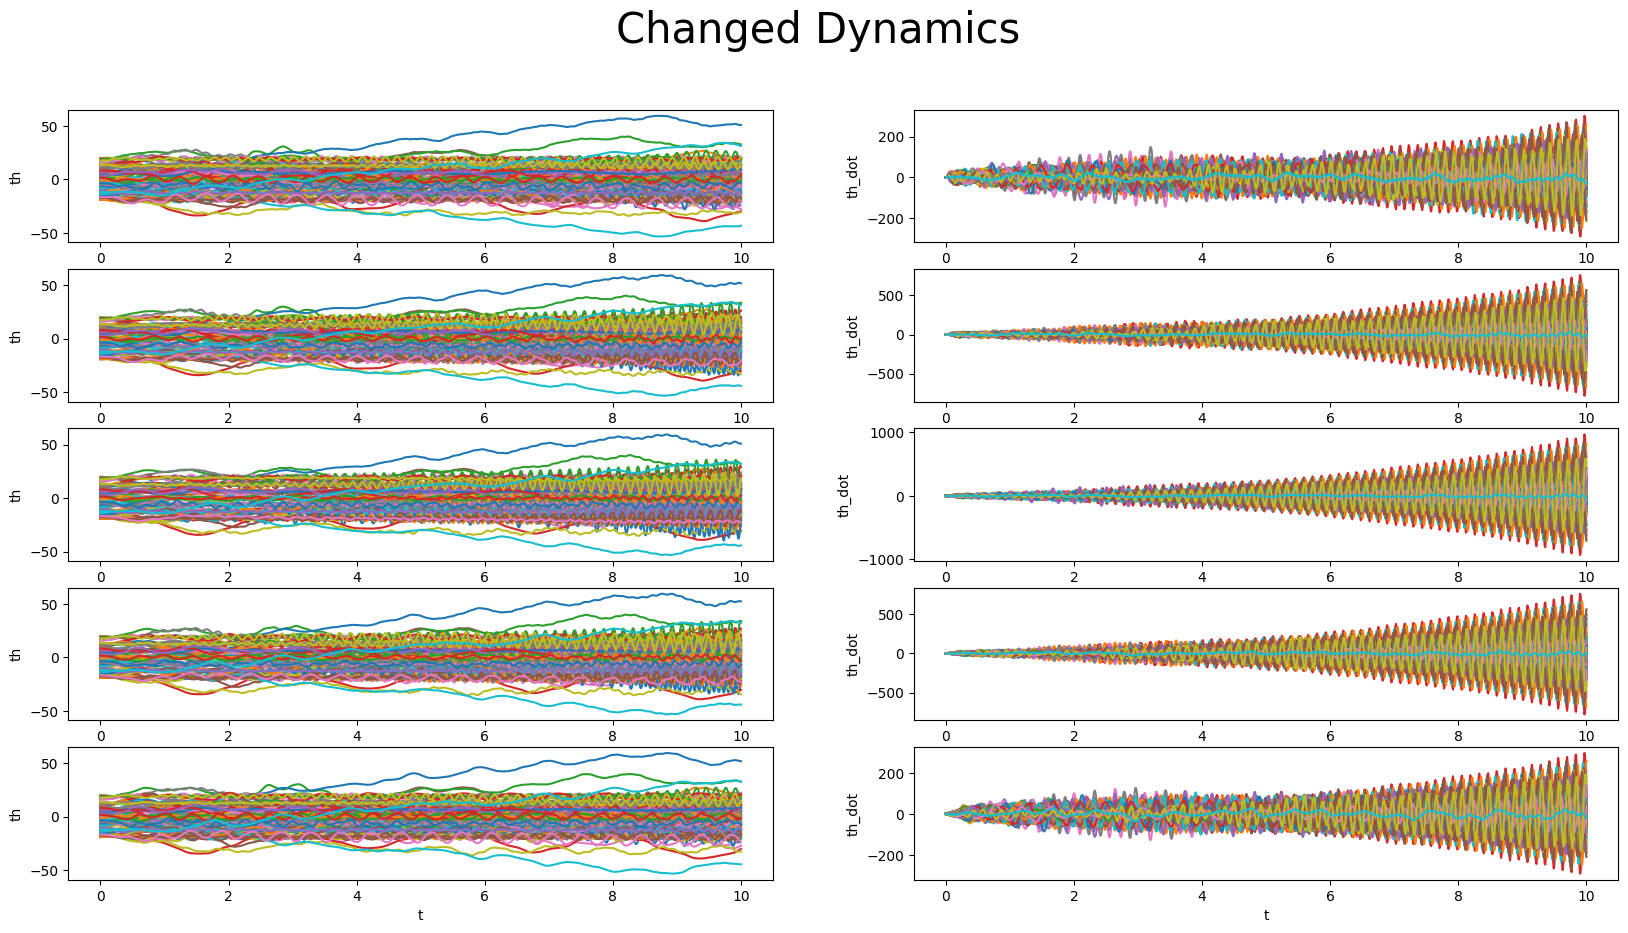

In [10]:
plt.figure(figsize = (20,10))
for j in range(num_traj):
    for i in range(N):
        plt.subplot(N,2,2*i+1)
        plt.xlabel("t")
        plt.ylabel(leg[0])
        plt.plot(t_train,X[j,:,2*i])

        plt.subplot(N,2,2*i+2)
        plt.xlabel("t")
        plt.ylabel(leg[1])
        plt.plot(t_train,X_changed[j,:,2*i+1])

plt.suptitle("Changed Dynamics", fontsize=30)
plt.show()

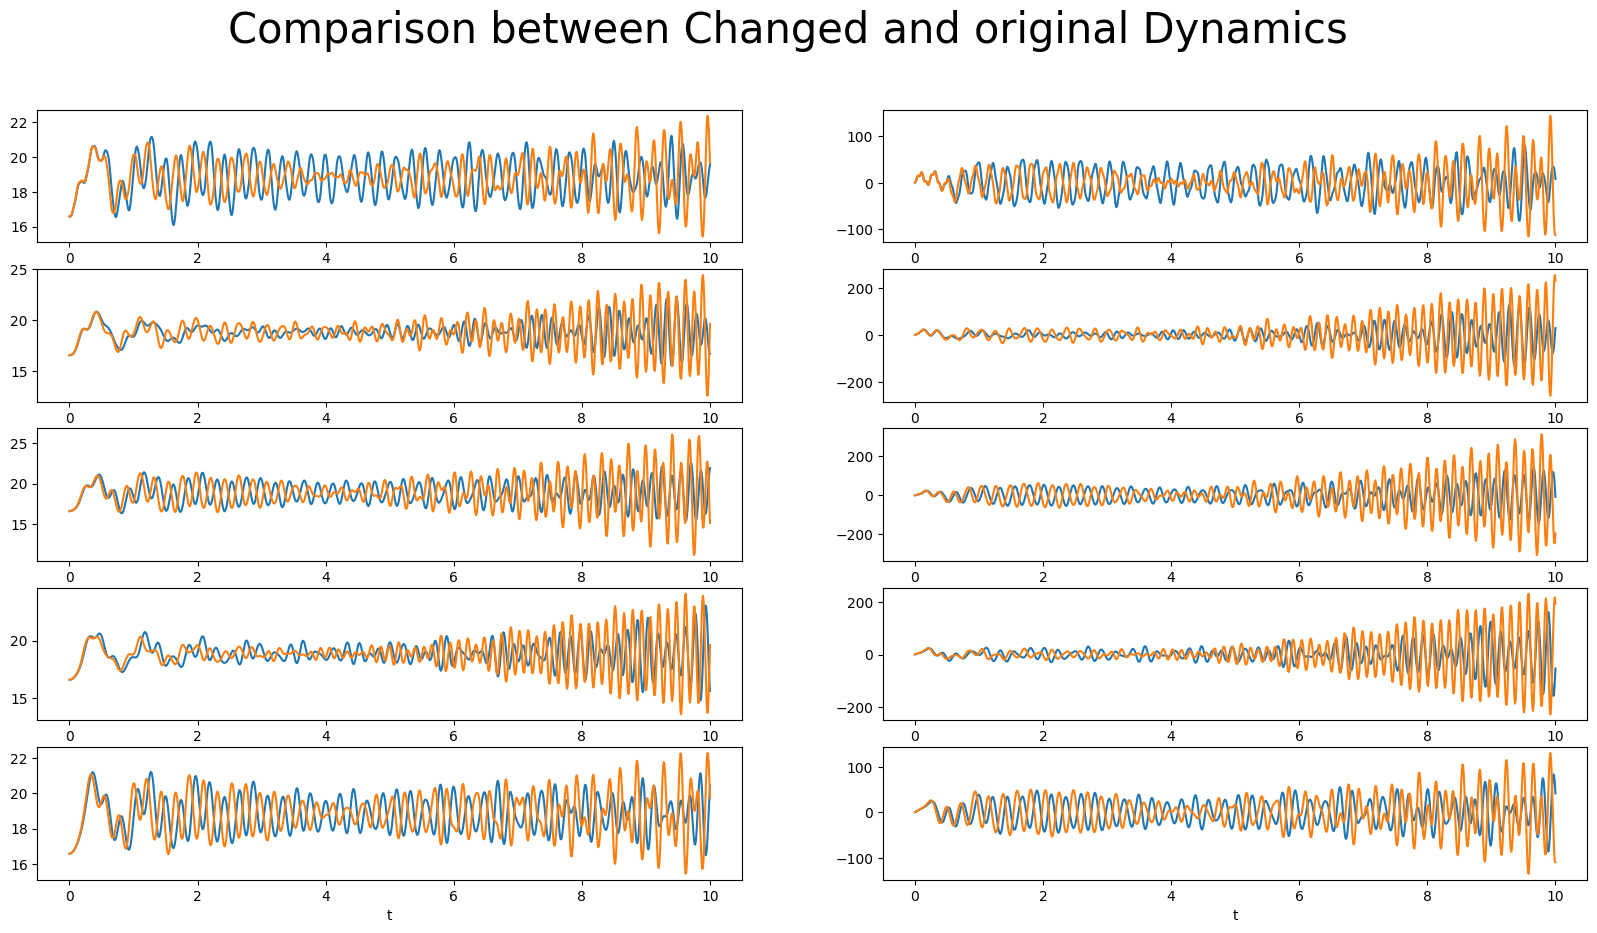

In [11]:
plt.figure(figsize = (20,10))
j = 10
for i in range(num_states):
    plt.subplot(N,2,i+1)
    plt.plot(t_train,X[j,:,i])
    plt.plot(t_train,X_changed[j,:,i])
    plt.xlabel("t")
    # plt.ylabel(leg[i])
plt.suptitle("Comparison between Changed and original Dynamics", fontsize=30)
plt.show()

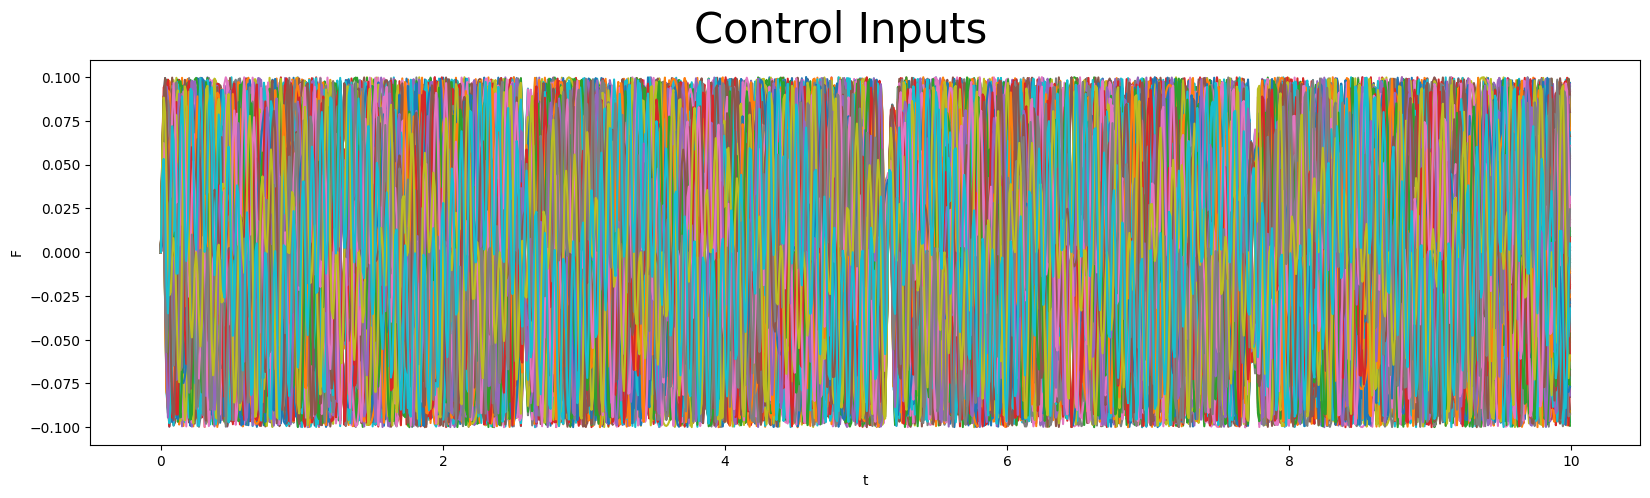

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize = (20,5))
for j in range(num_traj):
    for i in range(int(num_inputs)):
        plt.subplot(num_inputs,1,i+1)
        plt.xlabel("t")
        plt.ylabel("F")
        plt.plot(t_train[:-1], U[j,:,i])
plt.suptitle("Control Inputs", fontsize=30)
plt.show()

## Learning Koopman Models

In [13]:
# split training and vaidation datasets
xs_train, us_train = X[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X[num_train:,:,:],U[num_train:,:,:]

In [14]:
xs_train.shape, us_train.shape

((112, 1000, 10), (112, 999, 1))

In [15]:
# auto encoder parameters
net_params_lin = {}
net_params_lin['state_dim'] = num_states
net_params_lin['ctrl_dim'] = num_inputs
net_params_lin['encoder_hidden_width'] = 60
net_params_lin['encoder_hidden_depth'] = 3
net_params_lin['encoder_output_dim'] = 6
net_params_lin['optimizer'] = 'adam'
net_params_lin['activation_type'] = 'tanh'
net_params_lin['lr'] = 2e-4 # 5e-4
net_params_lin['epochs'] = 200
net_params_lin['batch_size'] = 256
net_params_lin['eig_loss'] = False
net_params_lin['eig_loss_coeff'] = 1.1
net_params_lin['lifted_loss_penalty'] = 0.4
net_params_lin['l2_reg'] = 1e-5
net_params_lin['l1_reg'] = 1e-5
net_params_lin['first_obs_const'] = True
net_params_lin['override_C'] = True # this makes the state a part of lifted state
net_params_lin['dt'] = dt

In [16]:
# Koopman Model
train = False
standardize = False
file_koop_linear = 'saved_models/sync_pendulum/linear/Koop_arch_N'+str(N)+'_L'+ str(sys_pars['l']) +'_Dim'+ str(net_params_lin['encoder_output_dim'])+'_dt_'+str(dt)+'.pth'

In [17]:
file_koop_linear

'saved_models/sync_pendulum/linear/Koop_arch_N5_L0.1_Dim6_dt_0.01.pth'

In [18]:
standardizer_u_kdnn = fit_standardizer(us_train, preprocessing.StandardScaler(with_mean = True))
standardizer_x_kdnn = fit_standardizer(xs_train, preprocessing.StandardScaler(with_mean = False))

In [19]:

if train == True:
    if standardize:
        net = KoopmanNetCtrl_linear(net_params_lin, standardizer_x=standardizer_x_kdnn, standardizer_u=standardizer_u_kdnn)
    else:
        net = KoopmanNetCtrl_linear(net_params_lin)
    model_koop_dnn_lin = KoopDNN_linear(net)
    model_koop_dnn_lin.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn_lin.model_pipeline(net_params_lin)
    model_koop_dnn_lin.construct_koopman_model()
    torch.save(model_koop_dnn_lin,file_koop_linear)
else:
    model_koop_dnn_lin = torch.load(file_koop_linear)

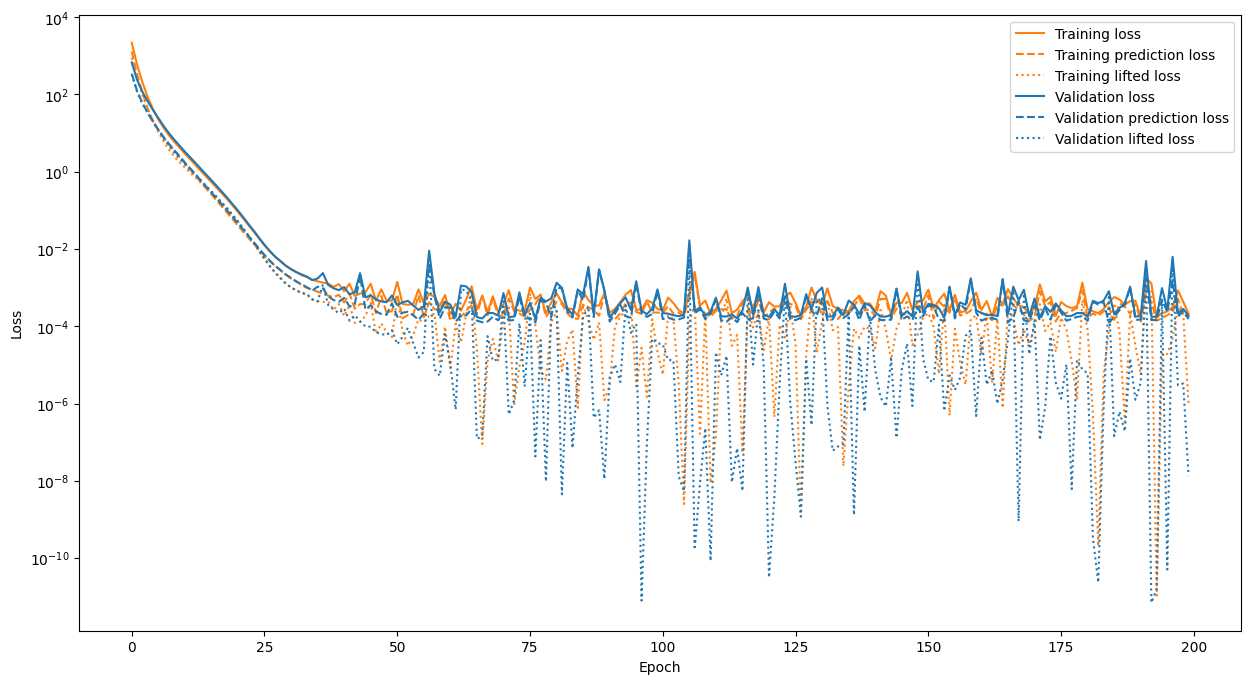

In [20]:
train_loss = [l[0] for l in model_koop_dnn_lin.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn_lin.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn_lin.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn_lin.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn_lin.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn_lin.val_loss_hist]
epochs = np.arange(0, net_params_lin['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

## Koopman Model Parameters

In [21]:
# test data parameters
num_snaps_test = 1000 # no. of snapshots
T_test = np.linspace(0,(num_snaps_test-1)*dt, num_snaps_test)
num_traj_test = 1 # no. of training examples
first_obs_const = int(net_params_lin['first_obs_const']) #only one state
override_C = net_params_lin['override_C']
if override_C:
    n_obs_lin = int(net_params_lin['encoder_output_dim']) + num_states + first_obs_const
else:
    n_obs_lin = int(net_params_lin['encoder_output_dim']) + first_obs_const

In [22]:
#generate data for testing
x_unchanged_test, x_changed_test, u_test = sync_pendulum_data_gen_multi(num_traj_test, num_snaps_test, sys_pars, sys_pars_new, sensor_noise,SNR_DB)

In [23]:
x_unchanged_test.shape, x_changed_test.shape, u_test.shape

((1, 1000, 10), (1, 1000, 10), (1, 999, 1))

In [24]:
A_lin = np.array(model_koop_dnn_lin.A)
B_lin = np.array(model_koop_dnn_lin.B)
C_lin = np.array(model_koop_dnn_lin.C)

print(A_lin.shape, B_lin.shape, C_lin.shape)
X_unchanged,_ = model_koop_dnn_lin.net.process(x_unchanged_test,data_u = u_test)
X_changed,_ = model_koop_dnn_lin.net.process(x_changed_test,data_u = u_test)

(17, 17) (17, 1) (10, 17)


In [25]:
X_unchanged.shape, X_changed.shape

((999, 21), (999, 21))

In [26]:
x_unchanged = X_unchanged[:, :num_states]
u = X_unchanged[:, num_states:num_states+num_inputs]
x_unchanged_prime = X_unchanged[:,num_states+num_inputs:]

x_changed = X_changed[:, :num_states]
x_changed_prime = X_changed[:,num_states+num_inputs:]

In [27]:
x_changed.shape, x_changed_prime.shape, x_unchanged.shape

((999, 10), (999, 10), (999, 10))

In [28]:
# initialize states
z_lin = np.zeros((n_obs_lin,num_snaps_test+1)).T   #lifted state
x_est_lin = np.zeros((num_states,num_snaps_test+1)).T #estimated values
z_lin[0,:] = lift(x_unchanged[0,:],model_koop_dnn_lin, net_params_lin)
x_est_lin[0,:] = np.matmul(z_lin[0,:],C_lin.T)


In [29]:
#compute the trajectory predicted by the Koopman model
for i in range(num_snaps_test-1):

    z_lin[i+1,:] = np.matmul(z_lin[i,:],A_lin.T)+np.matmul(u[i,:],B_lin.T)
    x_est_lin[i+1,:] = np.matmul(z_lin[i+1,:],C_lin.T)

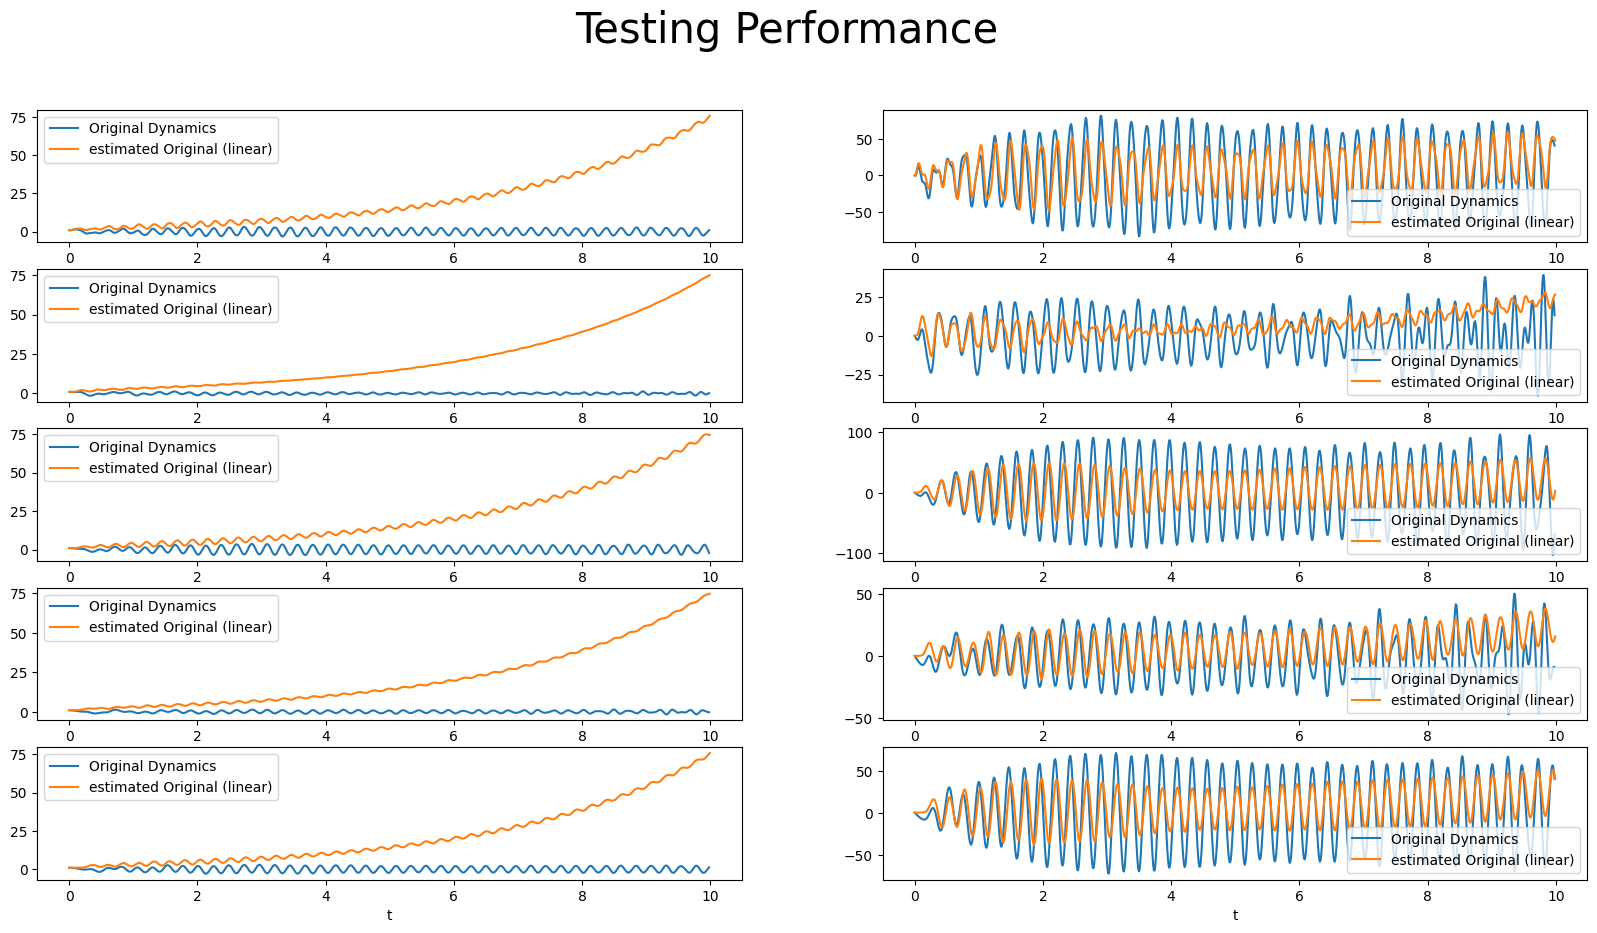

In [30]:
# state estimation evolution
plt.figure(figsize=(20, 10))
for i in range(int(num_states)):
    plt.subplot(N,2,i+1)
    plt.xlabel("t")
    # plt.ylabel(leg[i])
    plt.plot(T_test[:-1], x_unchanged[:,i],label ='Original Dynamics')
    plt.plot(T_test, x_est_lin[:-1,i],label = 'estimated Original (linear)')
    plt.legend()
plt.suptitle("Testing Performance", fontsize=30)
plt.show()

## Testing

## Adaptive Koopman with Control

In [31]:
from core.adapt_net_linear import AdaptNet_linear

In [32]:
"""Simultaneous adaptation and control"""

'Simultaneous adaptation and control'

In [33]:
from control_files.nmpc_osqp_adapt import NonlinearMPCController
from control_files.bmpc_osqp_adapt import bilinearMPCController
from dynamics.learned_models_control.bilinear_dynamics import bilinear_Dynamics
from dynamics.learned_models_control.linear_dynamics import linear_Dynamics
import scipy
import time

In [34]:
T_traj = 20 #length of trajectory
offset = 0*np.array([5,1,1,0.5]) #initial offset

t_ref = np.arange(0, T_traj, dt)    # Simulation time points, closed loop
traj_length = t_ref.size
x_ref = np.zeros((num_states,traj_length))
phi_dot_ref = 40 #reference angular velocity
for i in range(traj_length):
    x_ref[::2,i] = phi_dot_ref*i*dt #reference angles
    x_ref[1::2,i] = phi_dot_ref #reference angular velocities


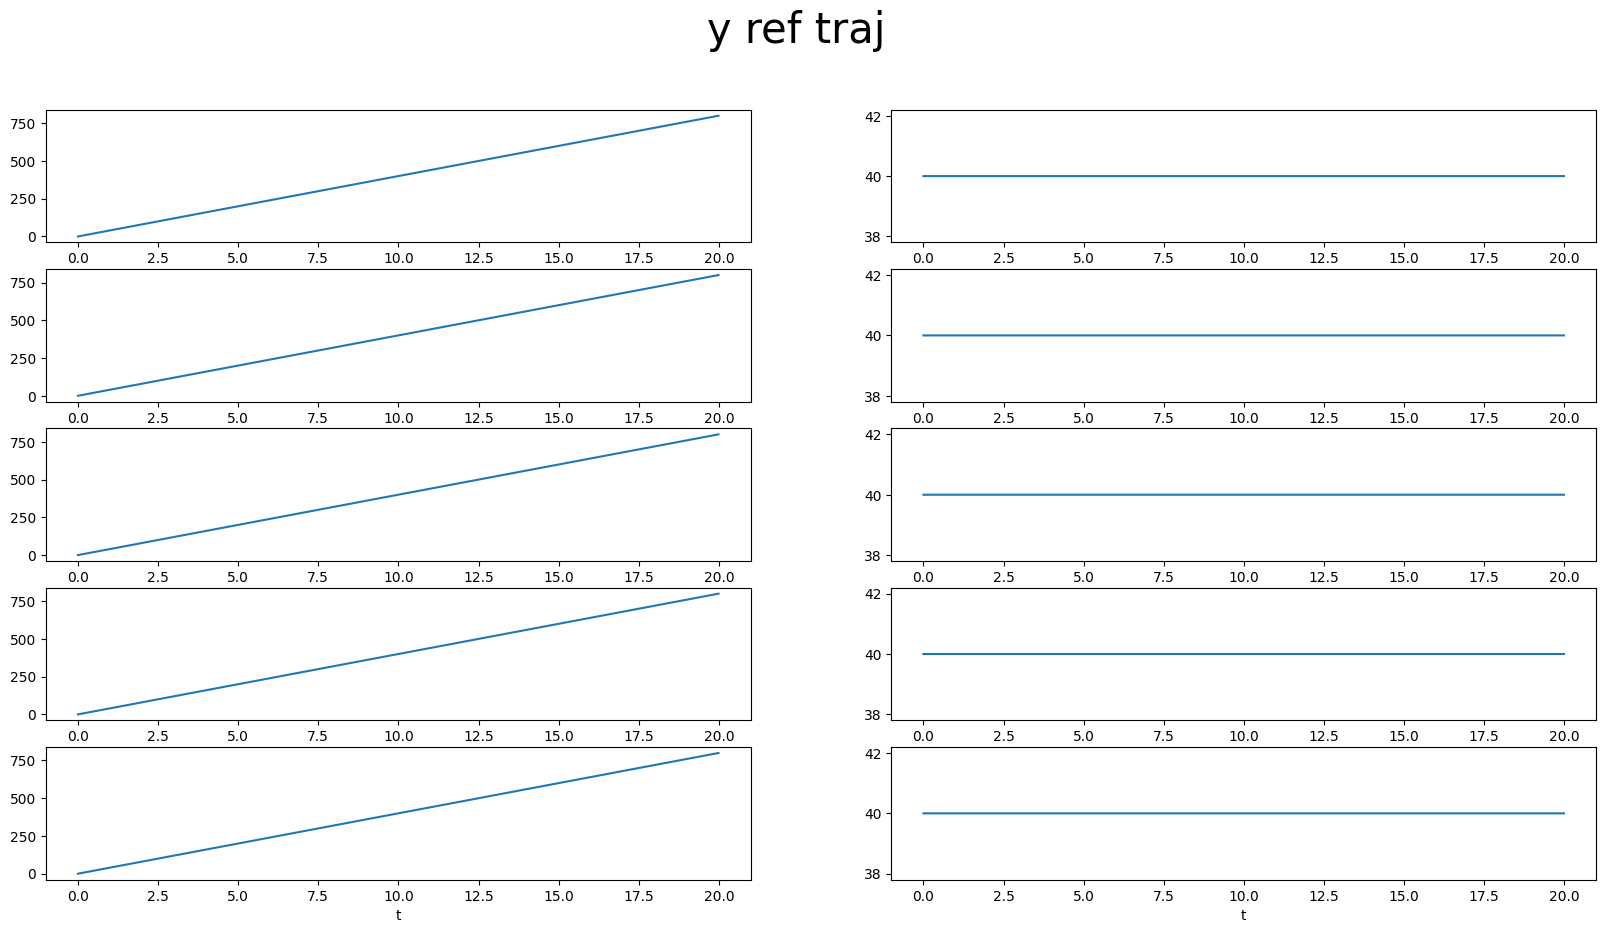

In [35]:
# state estimation evolution
leg_y = ['x','theta','x_dot', 'theta_dot']
plt.figure(figsize=(20, 10))
for i in range(num_states):
    plt.subplot(N,2,i+1)
    plt.xlabel("t")
    # plt.ylabel(leg_y[i])
    plt.plot(t_ref,x_ref[i,:])
plt.suptitle("y ref traj", fontsize=30)


In [36]:
"""tracking without adaptation"""
begin_linear_noadapt = time.time()
A_lin = np.array(model_koop_dnn_lin.A)
B_lin = np.array(model_koop_dnn_lin.B)
C_lin = np.array(model_koop_dnn_lin.C)

solver_settings = {} #solver setting parameters for OSQP solver
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 6
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = True
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

#controller that works on old model (unadapted)
N_lin_noadapt = 15 #length of horizon


Q_mpc_lin_noadapt = 10*scipy.sparse.diags(np.ones((num_states)))                     # State penalty matrix, trajectory generation
QN_mpc_lin_noadapt = 15*scipy.sparse.diags(np.ones((num_states)))         # Final state penalty matrix, trajectory generation
R_mpc_lin_noadapt = 10*scipy.sparse.eye(num_inputs)                       # Actuation penalty matrix, trajectory generation
R0_mpc_lin_noadapt = 10*scipy.sparse.csc_matrix(np.zeros(num_inputs))

max_iter_lin = 1

xmax_lin_noadapt = (phi_dot_ref*T_traj+50)*np.ones((num_states))                          # State constraints, trajectory generation
xmin_lin_noadapt = -xmax_lin_noadapt

umax_lin_noadapt = 10*np.ones((num_inputs))
umin_lin_noadapt = -umax_lin_noadapt

xt_lin_noadapt = np.zeros((traj_length+1, num_states))
xt_actual_lin_noadapt = np.zeros((traj_length, num_states))
xt_actual_lin_noadapt[0,:] = xt_lin_noadapt[0,:]

x_init_lin_noadapt = np.linspace(xt_actual_lin_noadapt[0,:], xt_actual_lin_noadapt[0,:], N_lin_noadapt+1)
u_init_lin_noadapt = 1*np.ones((num_inputs, N_lin_noadapt)).T

n_lift = A_lin.shape[0]
z_init_lin_noadapt = np.empty((N_lin_noadapt+1, n_lift))
z0 = lift(xt_actual_lin_noadapt[0,:], model_koop_dnn_lin, net_params_lin)
#lift initialized ststes
for i in range(N_lin_noadapt+1):
    z_init_lin_noadapt[i,:] = lift(x_init_lin_noadapt[i,:], model_koop_dnn_lin, net_params_lin)

linear_model_no_adapt = linear_Dynamics(scipy.sparse.csc_matrix(A_lin),scipy.sparse.csc_matrix(B_lin), C_lin) #define a linear model
controller_nmpc_lin_noadapt = NonlinearMPCController(linear_model_no_adapt, N_lin_noadapt, dt, umin_lin_noadapt, umax_lin_noadapt, xmin_lin_noadapt, xmax_lin_noadapt, Q_mpc_lin_noadapt, R_mpc_lin_noadapt, QN_mpc_lin_noadapt, solver_settings)
controller_nmpc_lin_noadapt.construct_controller(z_init_lin_noadapt, u_init_lin_noadapt, x_ref[:,0])

u_lin_noadapt = np.empty((num_inputs, traj_length-1)).T
z_lin_noadapt = np.empty((n_obs_lin, traj_length)).T

time_excess = 0

for k in range(traj_length-1):

    z_lin_noadapt[k,:] = lift(xt_actual_lin_noadapt[k,:], model_koop_dnn_lin, net_params_lin) #lifted state corresponding to current state

    controller_nmpc_lin_noadapt.solve_to_convergence(x_ref[:,k+1], z_lin_noadapt[k,:], controller_nmpc_lin_noadapt.z_init, controller_nmpc_lin_noadapt.u_init, max_iter = max_iter_lin, eps = 1e-3)
    controller_nmpc_lin_noadapt.update_initial_guess_()
    u_lin_noadapt[k,:] = controller_nmpc_lin_noadapt.cur_u[0,:]

    t1 = time.time()

    if sensor_noise:
        xt_actual_lin_noadapt[k+1,:] = FK_solver(xt_actual_lin_noadapt[k,:], u_lin_noadapt[k,:], sys_pars_new, sensor_noise, SNR_DB, k)
    else:
        xt_actual_lin_noadapt[k+1,:] = FK_solver(xt_actual_lin_noadapt[k,:], u_lin_noadapt[k,:], sys_pars_new, i=k)
    t2 = time.time()
    time_excess = (t2-t1) + time_excess

end_linear_noadapt = time.time()
time_linear_noadapt = (end_linear_noadapt - begin_linear_noadapt - time_excess)/traj_length

In [37]:
k

1998

In [43]:
"""Adaptation and control"""

begin_linear_adapt = time.time()
model_koop_dnn_lin = torch.load(file_koop_linear)

A_lin = np.array(model_koop_dnn_lin.A)
B_lin = np.array(model_koop_dnn_lin.B)
C_lin = np.array(model_koop_dnn_lin.C)


adapt_window_ctrl_lin = 1 #hyperparameter

adapt_params_control_lin = {}
adapt_params_control_lin['state_dim'] = num_states
adapt_params_control_lin['ctrl_dim'] = num_inputs
adapt_params_control_lin['lift_dim'] = net_params_lin["encoder_output_dim"]
adapt_params_control_lin['optimizer'] = 'adam'
adapt_params_control_lin['lr'] = 1e-5 # 5e-4
adapt_params_control_lin['epochs'] = 2
adapt_params_control_lin['batch_size'] = adapt_window_ctrl_lin
adapt_params_control_lin['l2_reg'] = 5e-2
adapt_params_control_lin['l1_reg'] = 5e-2
adapt_params_control_lin['state_loss_coeff'] = 1
adapt_params_control_lin['first_obs_const'] = net_params_lin["first_obs_const"]
adapt_params_control_lin['override_C'] = net_params_lin["override_C"] # this makes the state a part of lifted state
adapt_params_control_lin['warm_start'] = False

del_A_ctrl_lin = np.zeros_like(A_lin)
del_B_ctrl_lin = np.zeros_like(B_lin)

linear_model_adapt = linear_Dynamics(scipy.sparse.csc_matrix(A_lin),scipy.sparse.csc_matrix(B_lin), C_lin)

solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 10
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-7
solver_settings['eps_rel'] = 1e-7
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

#Closed loop performance evaluation parameters:
max_iter_lin = 1
N_lin = N_lin_noadapt #length of horizon
Q_mpc_lin = Q_mpc_lin_noadapt                       # State penalty matrix, trajectory generation
QN_mpc_lin = QN_mpc_lin_noadapt         # Final state penalty matrix, trajectory generation

R_mpc_lin = R_mpc_lin_noadapt                                    # Actuation penalty matrix, trajectory generation
R0_mpc_lin = R0_mpc_lin_noadapt

# Design trajectory:
xt_lin = np.zeros((traj_length, num_states))
xt_lin[0,:] = 0*x_ref[:,0]                   # Initial value, closed loop trajectory

ymax_lin = xmax_lin_noadapt                        # State constraints, trajectory generation
ymin_lin = xmin_lin_noadapt
umax_lin = umax_lin_noadapt
umin_lin = umin_lin_noadapt

# Define initial solution for SQP algorithm:
x_init_lin = np.linspace(xt_lin[0,:], xt_lin[0,:], N_lin+1)
u_init_lin = 0.1*np.ones((num_inputs, N_lin)).T

n_lift_lin = A_lin.shape[0]
z_init_lin = np.empty((N_lin+1, n_lift_lin))
z0_lin = lift(xt_lin[0,:], model_koop_dnn_lin, net_params_lin)
for i in range(N_lin+1):
    z_init_lin[i,:] = lift(x_init_lin[i,:], model_koop_dnn_lin, net_params_lin)

# initialize state matricies
u_ctrl_lin = np.zeros((traj_length-1, num_inputs))
z_new_dyn_lin = np.zeros((n_obs_lin, traj_length)).T   #lifted state
zt_old_dyn_lin = np.zeros((n_obs_lin, traj_length)).T #actual lifted state
del_z_prime_ctrl_lin = np.zeros((n_obs_lin, traj_length)).T
x_new_dyn_lin = np.zeros((num_states, traj_length)).T #estimated values
del_A_norm_ctrl_lin = np.zeros((traj_length,1))
del_B_norm_ctrl_lin = np.zeros((traj_length,1))

# initialize
z_new_dyn_lin[0,:] = zt_old_dyn_lin[0,:] = z0_lin
x_new_dyn_lin[0,:]  = xt_lin[0,:]

#controller that works on adapting model
controller_nmpc_adapt_lin = NonlinearMPCController(linear_model_adapt, N_lin, dt, umin_lin, umax_lin, ymin_lin, ymax_lin, Q_mpc_lin, R_mpc_lin, QN_mpc_lin, solver_settings)
controller_nmpc_adapt_lin.construct_controller(z_init_lin, u_init_lin, x_ref[:,0])

time_excess = 0
for i in range(traj_length-1):
    # incorrect dynamics
    z_new_dyn_lin[i,:] = lift(x_new_dyn_lin[i,:], model_koop_dnn_lin, net_params_lin)

    del_z_prime_ctrl_lin[i,:] = z_new_dyn_lin[i,:] - zt_old_dyn_lin[i,:]

    if i < adapt_window_ctrl_lin + 1 :
        del_A_ctrl_lin = np.zeros_like(A_lin)
        del_B_ctrl_lin = np.zeros_like(B_lin)
    # elif i % adapt_window_ctrl_lin == 0:
    else:
        del_Z_prime_ctrl_lin = del_z_prime_ctrl_lin[i-adapt_window_ctrl_lin:i,:].T
        Z_old_lin = zt_old_dyn_lin[i-(adapt_window_ctrl_lin+1):i-1].T
        U_old_lin = u_ctrl_lin[i-(adapt_window_ctrl_lin+1):i-1].T

        #invoke neural net for adapation
        adapt_network = AdaptNet_linear(adapt_params_control_lin)
        # adapt_network = AdaptNet_linear(adapt_params_control_lin, torch.tensor(del_A_ctrl_lin), torch.tensor(del_B_ctrl_lin))
        adapt_network.model_pipeline(Z_old_lin, U_old_lin, del_Z_prime_ctrl_lin, print_epoch = True)
        del_A_ctrl_lin, del_B_ctrl_lin = adapt_network.get_del_matrices()

    del_A_norm_ctrl_lin[i] = np.linalg.norm(del_A_ctrl_lin)
    del_B_norm_ctrl_lin[i] = np.linalg.norm(del_B_ctrl_lin)

    linear_model_adapt.A = scipy.sparse.csc_matrix(linear_model_adapt.A.toarray() + del_A_ctrl_lin)
    linear_model_adapt.B = scipy.sparse.csc_matrix(linear_model_adapt.B.toarray() + del_B_ctrl_lin)

    controller_nmpc_adapt_lin.solve_to_convergence(x_ref[:,i+1], z_new_dyn_lin[i,:], controller_nmpc_adapt_lin.z_init, controller_nmpc_adapt_lin.u_init, max_iter = max_iter_lin, eps = 1e-8)
    controller_nmpc_adapt_lin.update_initial_guess_()
    u_ctrl_lin[i,:] = controller_nmpc_adapt_lin.cur_u[0,:]

    t1 = time.time()

    # adapted model
    zt_old_dyn_lin[i+1,:] = controller_nmpc_adapt_lin.z_N0
    # xt_lin[i+1,:] = np.matmul(zt_old_dyn_lin[i+1,:],C_lin.T)
    if sensor_noise:
        x_new_dyn_lin[i+1,:] = FK_solver(x_new_dyn_lin[i,:], u_ctrl_lin[i,:], sys_pars_new, sensor_noise, SNR_DB, i)
    else:
        x_new_dyn_lin[i+1,:] = FK_solver(x_new_dyn_lin[i,:], u_ctrl_lin[i,:], sys_pars_new,i=i)

    t2 = time.time()
    time_excess = (t2-t1) + time_excess

end_linear_adapt = time.time()
time_linear_adapt = (end_linear_adapt - begin_linear_adapt - time_excess)/traj_length

In [44]:
i

1998

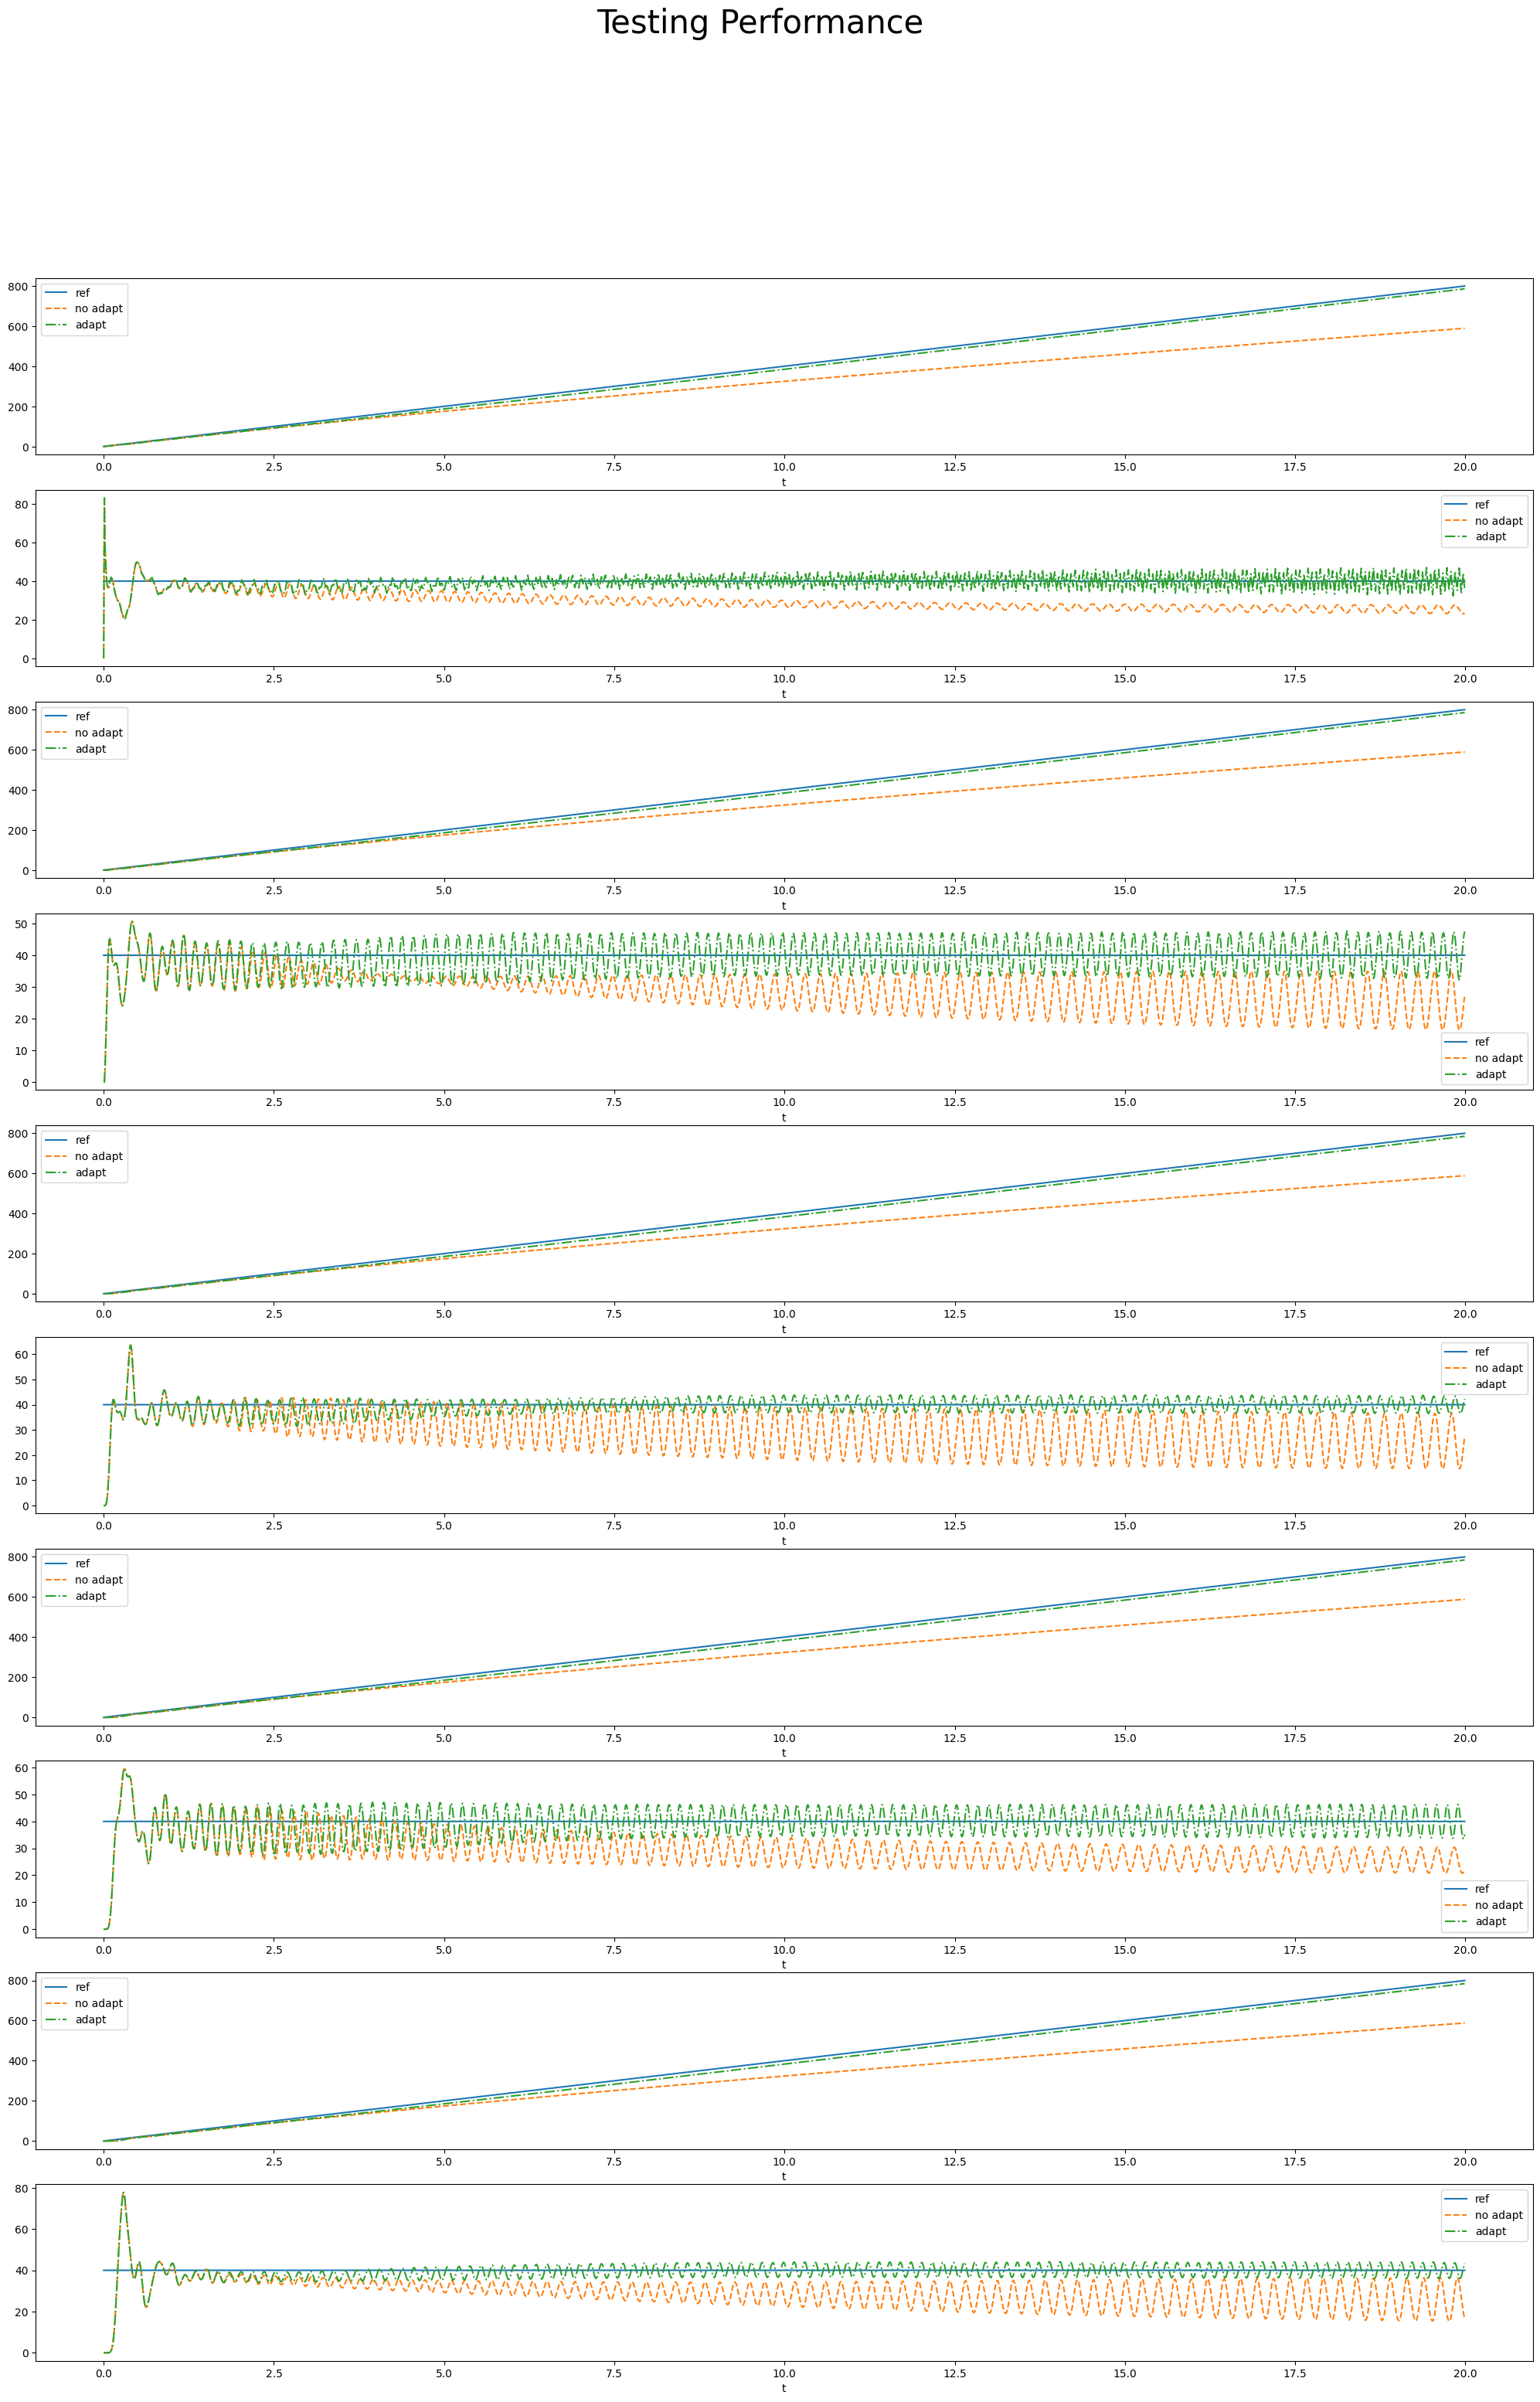

In [45]:
# state estimation evolution
plt.figure(figsize=(25,35))
for i in range(int(num_states)):
    plt.subplot(num_states,1,i+1)
    plt.xlabel("t")
    # plt.ylabel(leg[i])
    plt.plot(t_ref, x_ref[i,:], label = 'ref')
    plt.plot(t_ref, xt_actual_lin_noadapt[:,i],'--',label = "no adapt")
    plt.plot(t_ref, x_new_dyn_lin[:,i],'-.', label = "adapt")
    plt.legend()
plt.suptitle("simultaneous adaptation and control", fontsize=30)
plt.suptitle("Testing Performance", fontsize=30)

# plt.savefig(img_pth+'/adapt_synchronization.pdf')

plt.show()

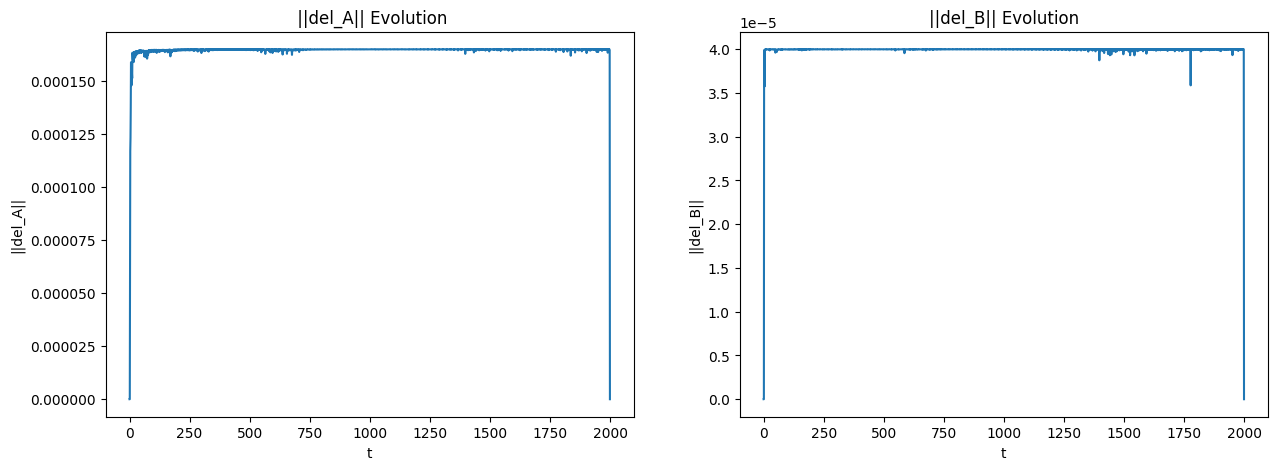

In [46]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].set_title(" ||del_A|| Evolution")
axs[1].set_title("||del_B|| Evolution")

axs[0].set(xlabel = 't', ylabel = '||del_A||')
axs[1].set(xlabel = 't', ylabel = '||del_B||')


axs[0].plot(del_A_norm_ctrl_lin)

axs[1].plot(del_B_norm_ctrl_lin)

plt.show()

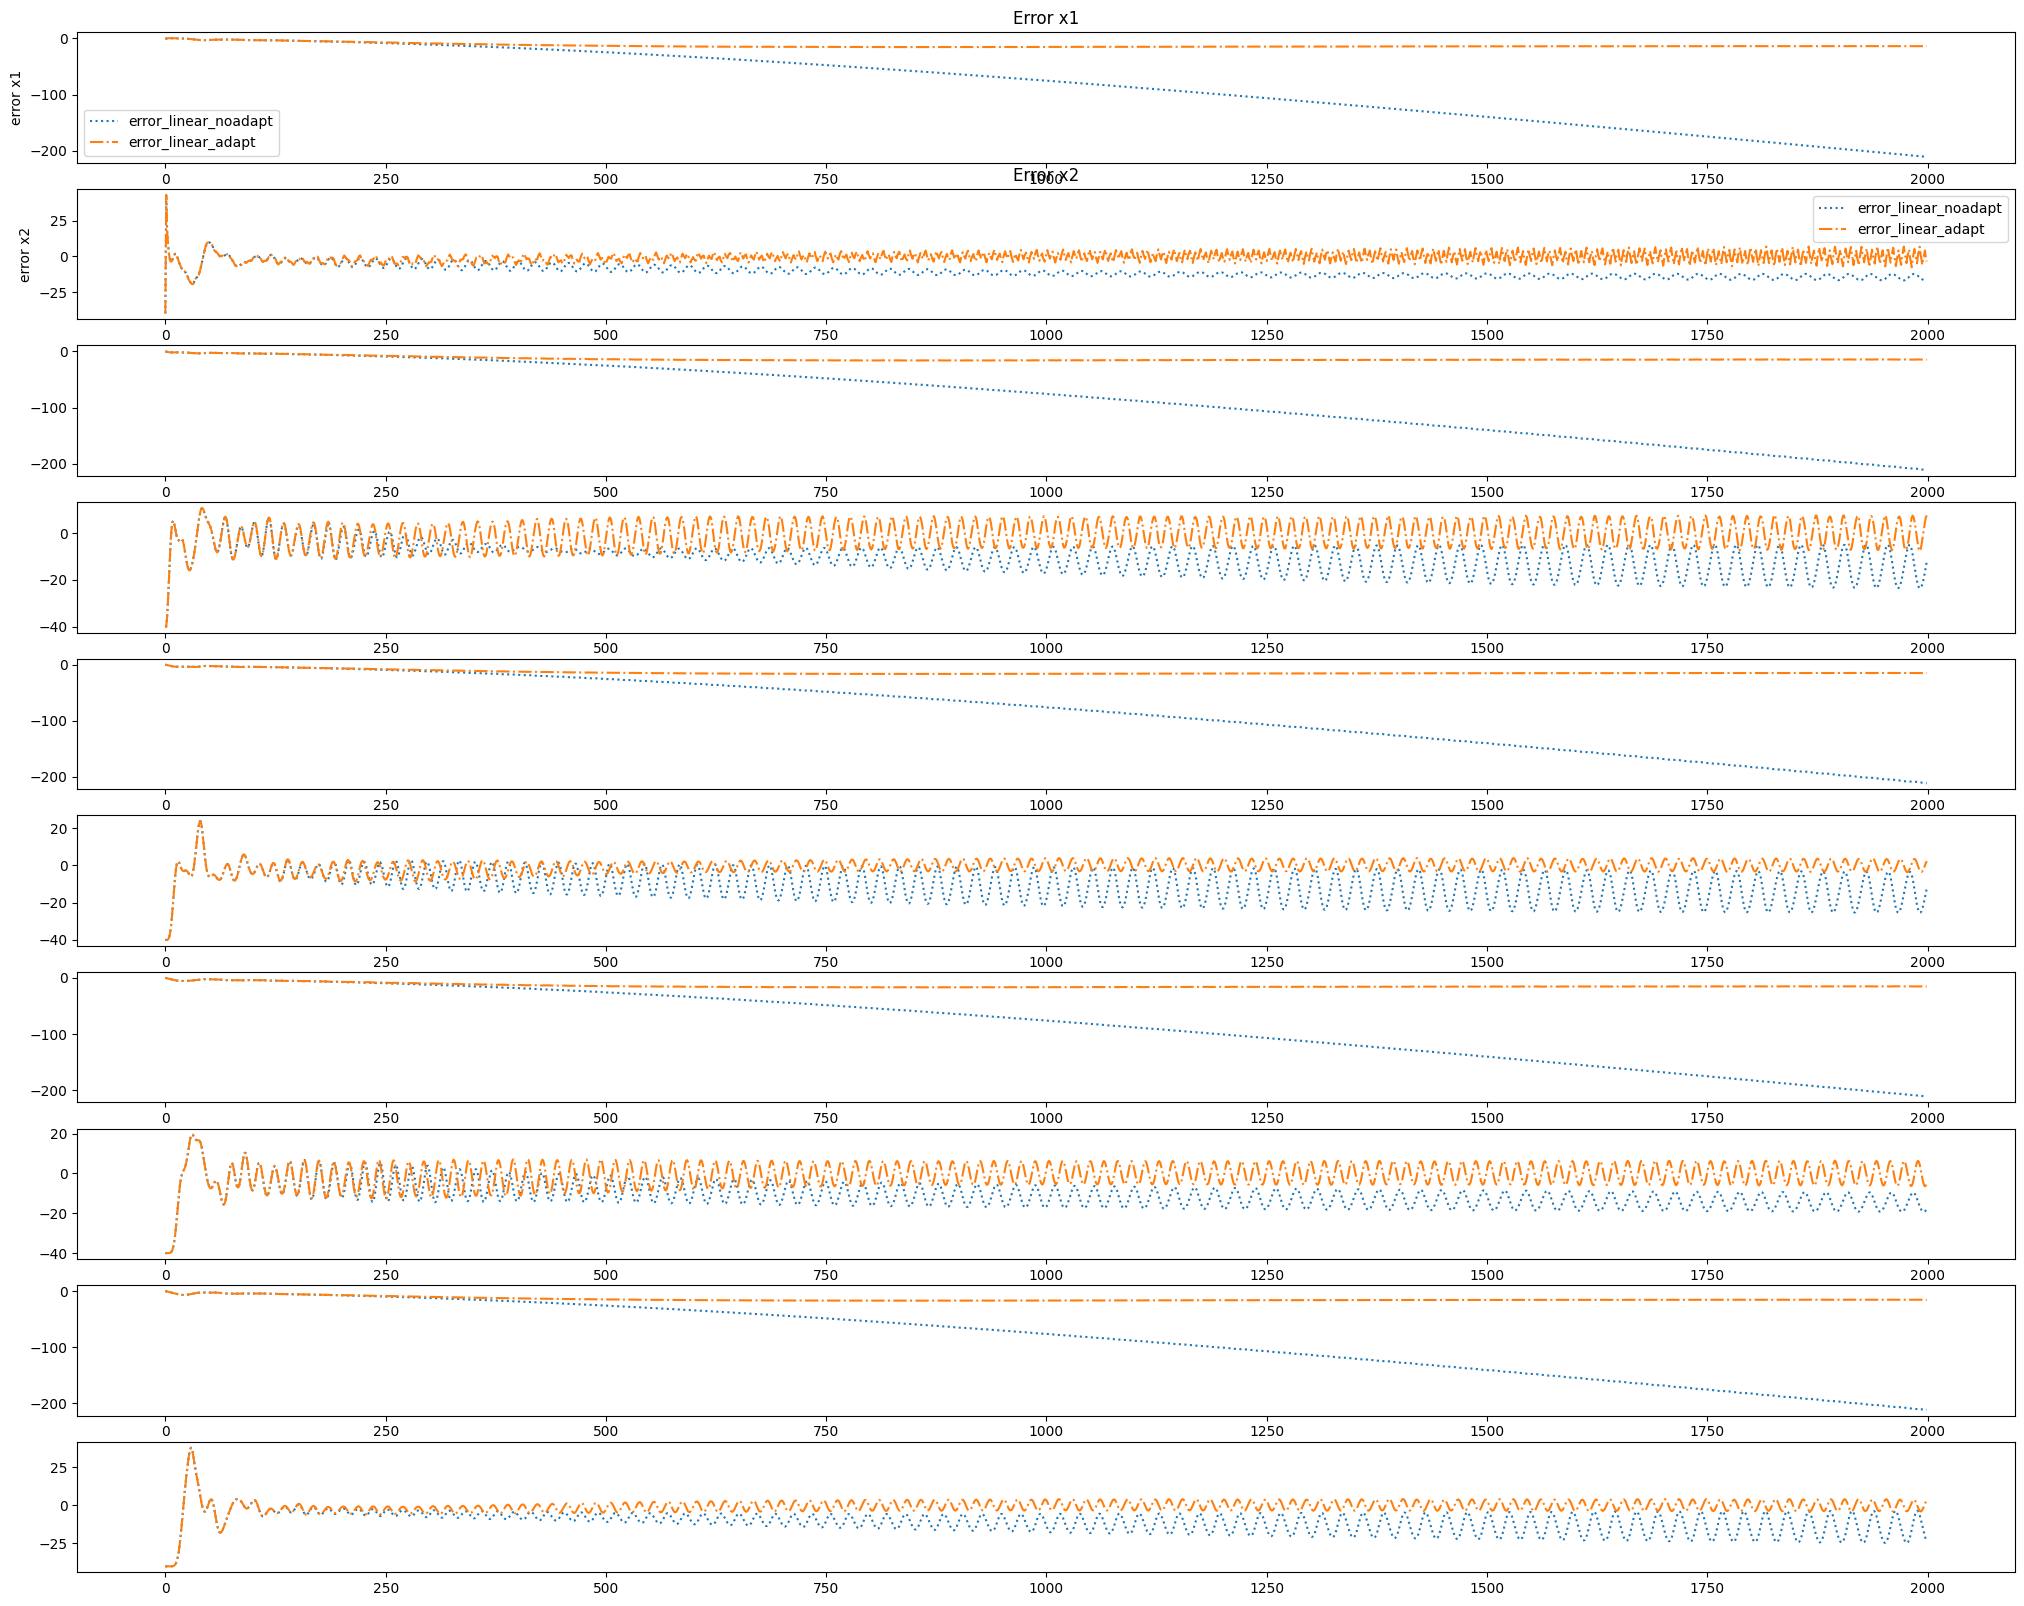

In [47]:
"""ERROR PLOTS"""
# plot dataset
fig, axs = plt.subplots(num_states,1,figsize=(25,20))
axs[0].set_title("Error x1")
axs[1].set_title("Error x2")

axs[0].set(xlabel = 't', ylabel = 'error x1')
axs[1].set(xlabel = 't', ylabel = 'error x2')


if linear:
    error_adapt_lin = x_new_dyn_lin - x_ref.T
    error_noadapt_lin = xt_actual_lin_noadapt - x_ref.T

    for i in range(num_states):
        axs[i].plot(error_noadapt_lin[:,i],":", label = 'error_linear_noadapt')
        axs[i].plot(error_adapt_lin[:,i],"-.", label = 'error_linear_adapt')

axs[0].legend()
axs[1].legend()


plt.show()

In [50]:
from prettytable import PrettyTable

In [51]:
error_adapt_lin_rel = np.divide(error_adapt_lin[1::,:], x_ref[:,1::].T)
error_noadapt_lin_rel = np.divide(error_noadapt_lin[1::,:], x_ref[:,1::].T)
rel_error_adapt_lin_norm = np.linalg.norm(error_adapt_lin_rel, axis = 0)/np.sqrt(t_ref[:-1].shape)
rel_error_noadapt_lin_norm = np.linalg.norm(error_noadapt_lin_rel, axis = 0)/np.sqrt(t_ref[:-1].shape)

error_adapt_lin_norm = np.linalg.norm(error_adapt_lin, axis = 0)/np.sqrt(t_ref.shape)
error_noadapt_lin_norm = np.linalg.norm(error_noadapt_lin, axis = 0)/np.sqrt(t_ref.shape)

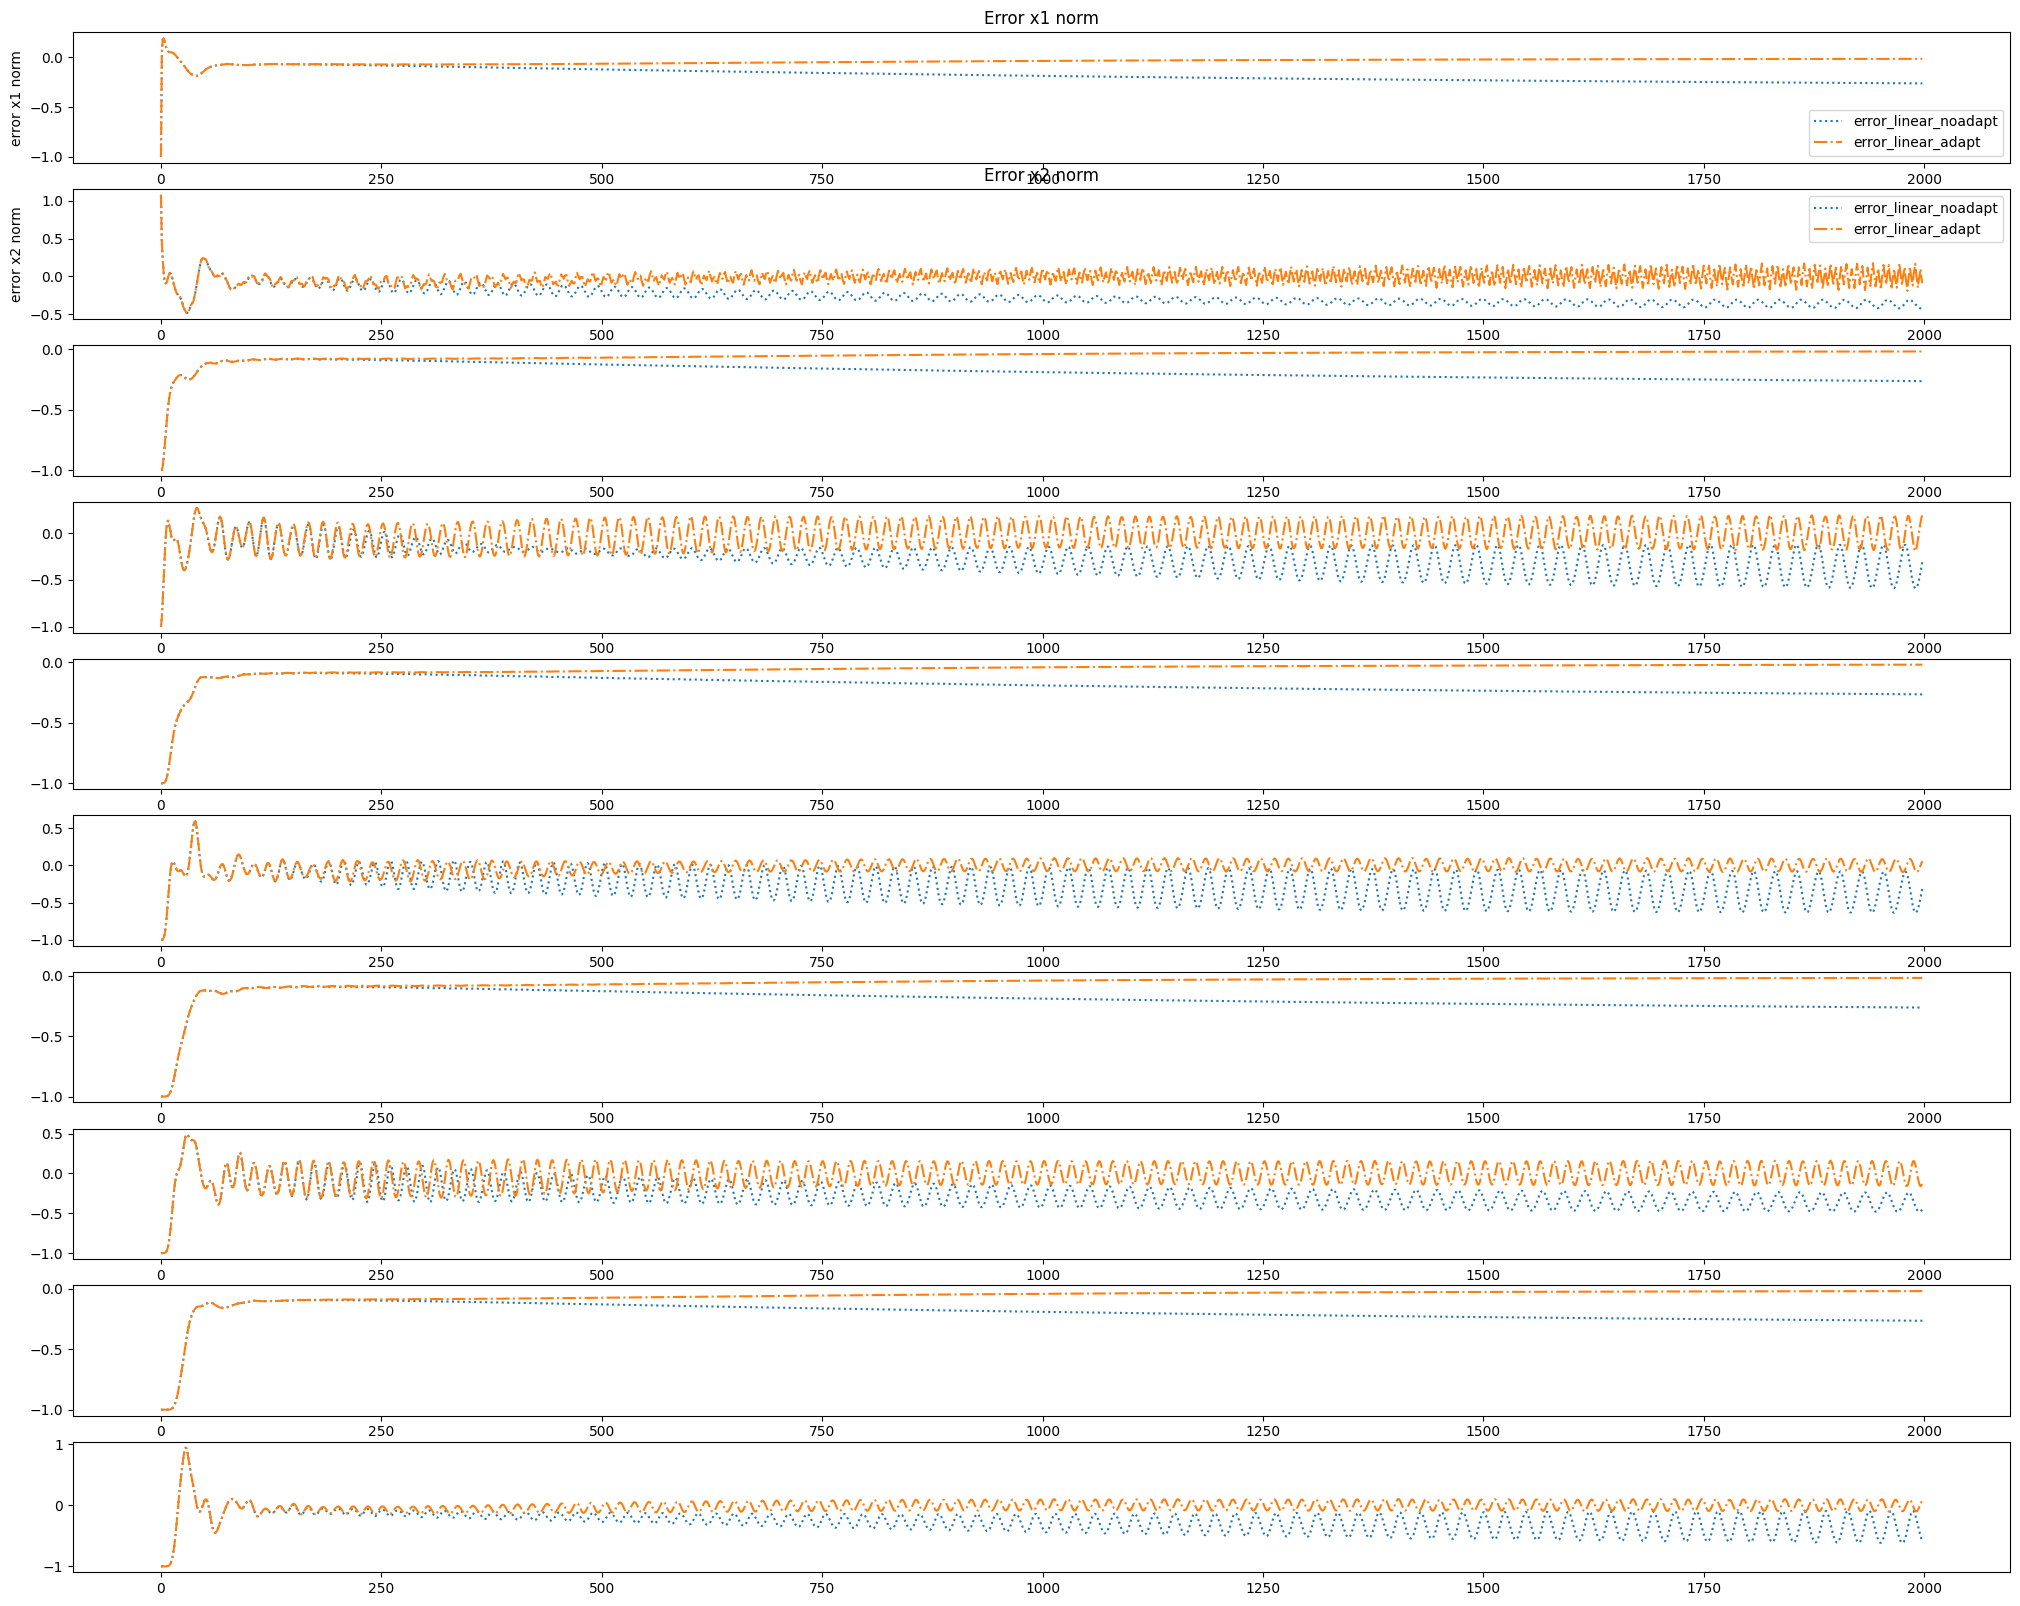

In [52]:
# plot dataset
fig, axs = plt.subplots(num_states,1,figsize=(25,20))
axs[0].set_title("Error x1 norm")
axs[1].set_title("Error x2 norm")

axs[0].set(xlabel = 't', ylabel = 'error x1 norm')
axs[1].set(xlabel = 't', ylabel = 'error x2 norm')


if linear:
    for i in range(num_states):
        axs[i].plot(error_noadapt_lin_rel[:,i],":", label = 'error_linear_noadapt')
        axs[i].plot(error_adapt_lin_rel[:,i],"-.", label = 'error_linear_adapt')

axs[0].legend()
axs[1].legend()


plt.show()

In [53]:
frac_imp = abs(error_adapt_lin_norm - error_noadapt_lin_norm)/error_noadapt_lin_norm
frac_imp.shape

(10,)

In [54]:
"""COMPUTE MEAN ERROR FOR ADAPTATION CASE"""
mean_theta_no_adapt = np.sum(rel_error_noadapt_lin_norm[0::2])/N
mean_theta_dot_no_adapt = np.sum(rel_error_noadapt_lin_norm[1::2])/N

mean_theta_adapt = np.sum(rel_error_adapt_lin_norm[0::2])/N
mean_theta_dot_adapt = np.sum(rel_error_adapt_lin_norm[1::2])/N

mean_theta_frac = np.sum(frac_imp[0::2])/N
mean_theta_dot_frac = np.sum(frac_imp[1::2])/N

mean_frac_imp = np.sum(frac_imp)/2/N

In [55]:
if linear:
    data_table = PrettyTable(['Pendulum','theta (no adapt)', 'theta (adapt)','frac improvement (theta)', 'theta_dot (no adapt)', 'theta_dot (adapt)','frac improvement (theta_dot)'])
for i in range(N):
    data_table.add_row([str(i+1), str(rel_error_noadapt_lin_norm[2*i]), str(rel_error_adapt_lin_norm[2*i]),str(frac_imp[2*i]),str(rel_error_noadapt_lin_norm[2*i+1]), str(rel_error_adapt_lin_norm[2*i+1]),str(frac_imp[2*i+1]) ])

data_table.add_row(['mean',str(mean_theta_no_adapt), str(mean_theta_adapt), str(mean_theta_frac), str(mean_theta_dot_no_adapt), str(mean_theta_dot_adapt), str(mean_theta_dot_frac)])

data_table.add_row(['mean_frac_imp','-', '-','-','-','-',mean_frac_imp])

In [56]:
frac_imp = abs(error_adapt_lin_norm - error_noadapt_lin_norm)/error_noadapt_lin_norm

In [57]:
"""COMPUTE MEAN ERROR FOR NO ADAPTATION CASE"""
mean_theta_no_adapt = np.sum(rel_error_noadapt_lin_norm[0::2])/N
mean_theta_dot_no_adapt = np.sum(rel_error_noadapt_lin_norm[1::2])/N

mean_theta_adapt = np.sum(rel_error_adapt_lin_norm[0::2])/N
mean_theta_dot_adapt = np.sum(rel_error_adapt_lin_norm[1::2])/N

mean_theta_frac = np.sum(frac_imp[0::2])/N
mean_theta_dot_frac = np.sum(frac_imp[1::2])/N

mean_frac_imp = np.sum(frac_imp)/2/N

In [58]:
if linear:
    data_table = PrettyTable(['Pendulum','theta (no adapt)', 'theta (adapt)','frac improvement (theta)', 'theta_dot (no adapt)', 'theta_dot (adapt)','frac improvement (theta_dot)'])
for i in range(N):
    data_table.add_row([str(i+1), str(rel_error_noadapt_lin_norm[2*i]), str(rel_error_adapt_lin_norm[2*i]),str(frac_imp[2*i]),str(rel_error_noadapt_lin_norm[2*i+1]), str(rel_error_adapt_lin_norm[2*i+1]),str(frac_imp[2*i+1]) ])

data_table.add_row(['mean',str(mean_theta_no_adapt), str(mean_theta_adapt), str(mean_theta_frac), str(mean_theta_dot_no_adapt), str(mean_theta_dot_adapt), str(mean_theta_dot_frac)])

data_table.add_row(['mean_frac_imp','-', '-','-','-','-',mean_frac_imp])

In [59]:
print(data_table)

+---------------+---------------------+---------------------+--------------------------+----------------------+---------------------+------------------------------+
|    Pendulum   |   theta (no adapt)  |    theta (adapt)    | frac improvement (theta) | theta_dot (no adapt) |  theta_dot (adapt)  | frac improvement (theta_dot) |
+---------------+---------------------+---------------------+--------------------------+----------------------+---------------------+------------------------------+
|       1       |  0.1894618739357318 | 0.05559950834759301 |    0.8758779764635887    |  0.2864646385565978  | 0.08733077830996781 |      0.6862583862267942      |
|       2       | 0.19928495904883606 | 0.08178138779498473 |    0.8705751528312815    | 0.30572589016730406  | 0.13791046210294977 |      0.5442323001542653      |
|       3       |  0.2092987127140947 | 0.10303338971241673 |    0.8666450359319785    |  0.3348983736406378  | 0.09988833111248126 |      0.6950291700495473      |
|       4 